In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import statsmodels.api as sm
from scipy import stats
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import random

In [2]:
import skfda
from skfda.ml.clustering import FuzzyCMeans, KMeans
class OSLFuzzyCluster:
    def __init__(self,data,n_cluster=3,init_cluster=None,fuzzifier=2):
        self.data = data
        self.nclust = n_cluster
        self.init_clust = init_cluster
        self.model = None
        self.predictClus = None
        self.fData = None
        self.fuzzifier=fuzzifier
        self.probCond = None
    
    def getFDataGrid(self, inp):
        inp = np.array(inp)
        n_dim = inp.ndim
        if n_dim == 1:
            grid_point = list(range(len(inp)))
            data_grid = []
            data_grid.append(inp)
            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        elif n_dim == 2:
            grid_point = list(range(len(inp[0])))
            data_grid = []
            for i in range(len(inp)):
                data_grid.append(inp[i])

            fd = skfda.FDataGrid(data_grid,grid_point)
            return fd
        else:
            raise Exception("Cannot handle more than 2 dimension for now") 
            return None
    
    def update_data(self,data):
        self.data = np.append(self.data,np.array(data))
        return
        
        
    def fit(self):    
        self.fData = self.getFDataGrid(self.data)
        if self.fData == None:
            print("No data to cluster")
            return None
        self.model = FuzzyCMeans(n_clusters=self.nclust,n_init=5 ,init=self.init_clust,fuzzifier=self.fuzzifier,max_iter=400,random_state=0)
        self.model.fit(self.fData)
        self.predictClus = self.model.predict_proba(self.fData)
        return self.model,self.predictClus
    
    def predict_clust(self,data):
        fd = self.getFDataGrid(data)
        return self.model.predict_proba(fd)
    
    def get_center(self):
        return self.model.cluster_centers_.data_matrix
        
    def get_CondProb(self):
        prob_count = self.predictClus
        n_cluster = self.nclust

        PCount = [0 for _ in range(n_cluster)]
        PTP_count = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(len(prob_count)):
            for c in range(n_cluster):
                PCount[c] += prob_count[i][c]
                if i>0:
                    for cn in range(n_cluster):
                        PTP_count[cn][c] += prob_count[i-1][cn]*prob_count[i][c]


        self.probCond = [[0 for _ in range(n_cluster)] for _ in range(n_cluster)]
        for i in range(n_cluster):
            for j in range(n_cluster):
                self.probCond[i][j] = round(PTP_count[i][j]/PCount[i],3) # P(Y(t) in j / Y(t-1) in i)
        return self.probCond
    

        

In [3]:
class OSLARMA:
    def __init__(self,endog,p=3,exog=None,weight=None):
        self.endog = endog
        self.p = p
        self.exog = exog
        self.w = weight
        self.model = None
        self.xData = None
        self.yData = None
        self.ylast = None
        self.fitData = None
    
    def summary(self):
        return self.model.summary()
        
    def getShifted_Dataset(self):
        # Currently accepting only one dimensional exog if any
        if self.p < 1:
            print('Error needs atleast 1')
            return None
        plen = self.p
        df_temp = pd.DataFrame()
        df_temp['endog'] = self.endog
        # Getting shifted dataset
        for i in range(1,self.p+1):
            df_temp['Shift_endog_%d' % i] = df_temp['endog'].shift(i)
        if self.exog is not None:
            df_temp['exog'] = self.exog
            plen += 1
        if self.w is not None:
            df_temp['Weight'] = self.w
        elif self.w is None:
            df_temp['Weight'] = np.ones(self.endog.shape[0])

        df_train_2 = df_temp.dropna()
        X_train = df_train_2.iloc[:,1:plen+1].values.reshape(-1,plen)
        y_train = df_train_2.iloc[:,0].values.reshape(-1,1)
        sample_weight = df_train_2['Weight'].values
        X_last = df_train_2.iloc[-1,:self.p].values.reshape(-1,self.p)
        return [y_train,X_train,X_last[0],sample_weight]
    
    def update_data(self,endog,exog=None,weight=None):
        # Addpending the data
        self.endog = np.concatenate((self.endog,np.array(endog)))
        
        if exog is not None:
            self.exog = np.concatenate((self.exog, np.array(exog)))
        if weight is not None:
            self.w = np.concatenate((self.w,np.array(weight)))
        # This part is helps adding the new observed data and can be used to retrain the model
        self.ylast = self.endog[-1:-(self.p+1):-1]
#         #Test Code
#         print("Update",self.ylast)
#         #End testcode
        return
    
    def WeighedLearn(self,y,X,weight):
        import statsmodels.api as sm
        X_sm = sm.add_constant(X)
        model = sm.WLS(y,X_sm,weights=weight)
        result = model.fit()
        return result
    
    def fit(self):
        tData = self.getShifted_Dataset()
#         self.yData = tData[0]
#         self.xData = tData[1]
        self.ylast = tData[2]
#         weight = tData[3]
        self.model = self.WeighedLearn(tData[0],tData[1],weight=tData[3])
        return self.model,self.ylast
           
    def get_predict(self,steps=1,exog=None):
        # Ensure that the exog and model have the same dimension. Currently we have only one dim of exog
        if exog is not None:
            #Update
            if len(exog) != steps:
                print("Exog variable incorrect")
                return None
        # Assume exog is there
        Y_out = []
#         print("exog",exog)
        if exog is not None:
            X_update = []        
            X_inp = self.ylast
#             print("ylast",self.ylast)
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                X_test.append(exog[i])
#                 print("Xtest",X_test)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
#                 print(X_inp)
            # Predict the data
            return Y_out
        else:
            #No exog
            X_inp = self.ylast
            for i in range(steps):
                X_test = [1.0]
                X_test.extend(X_inp)
                y_pred = self.model.get_prediction(X_test).predicted_mean
                Y_out.extend(y_pred)
                X_i = list(y_pred)
                X_i.extend(X_inp[:-1])
                X_inp = X_i
    #             print(X_inp)
            return Y_out        

In [4]:
# Data Modifier Code
def getDataFrame(fileName):
    myDf = pd.read_csv(fileName)
    myDf['memLoad'] = myDf['memUse']*100/myDf['memTot']
    myDf['memScore'] = myDf['memLoad']*myDf['memfreq']/825000000
    myDf['memF'] = myDf['memfreq']*100/825000000
    myDf['cpuScore'] = myDf['cpuload']*myDf['cpufreq']/1400000
    myDf['cpuF'] = myDf['cpufreq']*100/1000000
    return myDf

def getNewDataFrame(fileName):
    myDf = pd.read_csv(fileName)
#     myDf['memLoad'] = myDf['memUse']*100/myDf['memTot']
    myDf['mUtil'] = myDf['mUtil'].clip(upper=100)
    myDf['mScore'] = myDf['mUtil']*myDf['mFreq']/825000000
    myDf['memF'] = myDf['mFreq']*100/825000000
    myDf['bcScore'] = myDf['bUtil']*myDf['bFreq']/1400000
#     myDf['cpuF'] = myDf['cpufreq']*100/1000000
    return myDf

def getDataMatrix(dx,dy=None):
    data_matrix=[]
    if dy is None:
        for v in dx:
            data_matrix.append([round(v,2),round(v,2)])
    else:
        for v in zip(dx,dy):
            data_matrix.append([round(v[0],2),round(v[1],2)])
    return data_matrix

In [122]:
# Latest Code
def main():
    utilData = getNewDataFrame('./UtilTestFinal')
    print("Size of data:",utilData.shape)
    dy = utilData.bUtil.dropna().to_numpy()
    dz = utilData.mUtil.diff().dropna().to_numpy()
#     dy = utilData.cpuload.dropna().to_numpy()
    nCluster = 15
    y_train = dy[2:7001]
    x_train = dz[:6999]
    # Predicting in a different range
    TEST_START = 8301
    y_test = dy[TEST_START:]
    x_test = dz[TEST_START-2:]
    
    
    y_dmat = getDataMatrix(y_train,x_train)
    myClust = OSLFuzzyCluster(y_dmat,n_cluster=nCluster)
    _, data_weight = myClust.fit()
#     print(dy[0])
#     print(data_weight)
#     print("data_cluster", myClust.get_center())
    trans_prob = myClust.get_CondProb()
    #Removing Print
#     print(trans_prob)
#     print("\n\n\n")
    # We will send the weights of the data and then train these models
    models = []
    # Train the models
    for i in range(nCluster):
        model = OSLARMA(y_train,p=4,exog=x_train, weight=data_weight[:,i])
        model.fit()
#         print(model.summary())
        models.append(model)
    
    # Models are trained now begin prediction
#     print("last actual value", y_train[-1],"Likelihood cluster", myClust.predict_clust([ y_train[-1], y_train[-1]]))
    y_prior = dy[TEST_START-1]
    x_prior = dz[TEST_START-3]
    Y_ACT=[]
    Y_PRED=[]
    for i in range(100):
        # Get prob of P(Y(t-1) in i) using cluster
        P_prior = myClust.predict_clust([y_prior,x_prior])[0]
#         print("P",P_prior)
        P_like = []
        # Predict likelihood of Y(t) in cluster based on transition prob
        for k in range(nCluster):
            prob = 0
            for j in range(nCluster):
                prob += trans_prob[j][k]*P_prior[j]
            P_like.append(prob)
        
#         print("PLike",P_like)
        y_act = y_test[i]
        y_prior = y_act
        x_prior = dz[TEST_START-2+i]
        y_pred = []
        y_est = 0
        for j in range(nCluster):
            y_pred.append(models[j].get_predict(1,[x_prior])[0])
            y_est += y_pred[-1]*P_like[j]
        
#         print(i, y_act,y_est,x_prior)
        Y_ACT.append(y_act)
        Y_PRED.append(y_est)
        for j in range(nCluster):
            models[j].update_data([y_act],[x_prior])
    df_plot = pd.DataFrame()
    df_plot['Actual'] = Y_ACT
    df_plot['Predicted'] = Y_PRED
    df_plot[['Actual','Predicted']].plot()

# Notes:
The estimation ends up in a steady state, and does not update if it observes an mismatch with prediction. Need some sort of nudge, where steady state errors can be handled better

Size of data: (8560, 10)


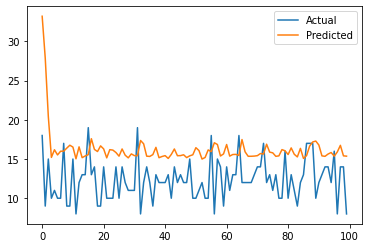

In [123]:
main()

In [ ]:
# Old Code
# Testing  
def main():
    utilData = getDataFrame('./Util_Run1.csv')
    dy = utilData.cpuload.dropna().to_numpy()
    dz = utilData.memLoad.dropna().to_numpy()
#     dy = utilData.cpuload.dropna().to_numpy()
    nCluster = 5
    y_train = dy[:2000]
    x_train = dz [:2000]
    y_test = dy[2000:]
    x_test = dz[2000:]
    y_dmat = getDataMatrix(y_train,x_train)
    myClust = OSLFuzzyCluster(y_dmat,n_cluster=nCluster)
    _, data_weight = myClust.fit()
#     print(dy[0])
#     print(data_weight)
#     print("data_cluster", myClust.get_center())
    trans_prob = myClust.get_CondProb()
    print(trans_prob)
    print("\n\n\n")
    # We will send the weights of the data and then train these models
    models = []
    # Train the models
    for i in range(nCluster):
        model = OSLARMA(y_train,p=4,exog=x_train, weight=data_weight[:,i])
        model.fit()
#         print(model.summary())
        models.append(model)
    
    # Models are trained now begin prediction
#     print("last actual value", y_train[-1],"Likelihood cluster", myClust.predict_clust([ y_train[-1], y_train[-1]]))
    y_prior = y_train[-1]
    x_prior = x_train[-1]
    for i in range(50):
        # Get prob of P(Y(t-1) in i) using cluster
        P_prior = myClust.predict_clust([y_prior,x_prior])[0]
#         print("P",P_prior)
        P_like = []
        # Predict likelihood of Y(t) in cluster based on transition prob
        for k in range(nCluster):
            prob = 0
            for j in range(nCluster):
                prob += trans_prob[j][k]*P_prior[j]
            P_like.append(prob)
        
#         print("PLike",P_like)
        y_act = y_test[i]
        y_prior = y_act
        x_prior = x_test[i]
        y_pred = []
        y_est = 0
        for j in range(nCluster):
            y_pred.append(models[j].get_predict(1,[x_prior])[0])
            y_est += y_pred[-1]*P_like[j]
        
        print(i, y_act,y_est,x_prior)
        
        for j in range(nCluster):
            models[j].update_data([y_act],[x_prior])
            

    